In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist

import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
%matplotlib inline

from keras.layers import Activation

from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()


11493376/11490434 [==============================] - 1s 0us/step


(60000, 28, 28)


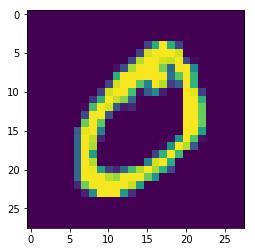

In [3]:
print (X_train.shape)
plt.imshow(X_train[1])

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [0]:
y_train[:10]
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [7]:
Y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

# Function for plotting future maps

In [0]:

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[2]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_227', model = None):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))


# Step 1

## Basic architecture of model  

In [10]:
model = Sequential()
 
model.add(Convolution2D(16, 3, 3, activation='relu', input_shape=(28,28,1))) #26 GRF(Global receptive field)

model.add(Convolution2D(20, 3, 3, activation='relu')) #24

model.add(MaxPooling2D(pool_size=(2, 2)))#11

model.add(Convolution2D(10, 1, 1, activation='relu')) #11


model.add(Convolution2D(16, 3, 3, activation='relu'))#9

model.add(Convolution2D(16, 3, 3, activation='relu'))#7

model.add(Convolution2D(16, 3, 3, activation='relu'))#5

model.add(Convolution2D(16, 3, 3, activation='relu'))#3

model.add(Convolution2D(10, 4, 4))

model.add(Flatten())
model.add(Activation('softmax'))


model.summary()

W0819 18:35:18.985002 140454928721792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  This is separate from the ipykernel package so we can avoid doing imports until
W0819 18:35:19.005771 140454928721792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 18:35:19.010334 140454928721792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

/usr/local/l

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 20)        2900      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 10)        210       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        1456      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 16)          2320      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 16)          2320      
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D

In [11]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./mdl_wts.hdf5', save_best_only=True, monitor='val_acc', mode='max')
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1, validation_data=(X_test, Y_test),callbacks=[earlyStopping, mcp_save])


W0819 18:35:20.308439 140454928721792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0819 18:35:20.335805 140454928721792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0819 18:35:20.422536 140454928721792 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0819 18:35:20.601584 140454928721792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 14s 226us/step - loss: 0.2319 - acc: 0.9285 - val_loss: 0.0896 - val_acc: 0.9727
Epoch 2/15
60000/60000 [==============================] - 11s 180us/step - loss: 0.0803 - acc: 0.9757 - val_loss: 0.0837 - val_acc: 0.9752
Epoch 3/15
60000/60000 [==============================] - 11s 180us/step - loss: 0.0615 - acc: 0.9811 - val_loss: 0.0465 - val_acc: 0.9861
Epoch 4/15
60000/60000 [==============================] - 11s 186us/step - loss: 0.0509 - acc: 0.9843 - val_loss: 0.0467 - val_acc: 0.9865
Epoch 5/15
60000/60000 [==============================] - 11s 181us/step - loss: 0.0424 - acc: 0.9865 - val_loss: 0.0394 - val_acc: 0.9872
Epoch 6/15
60000/60000 [==============================] - 11s 180us/step - loss: 0.0366 - acc: 0.9885 - val_loss: 0.0348 - val_acc: 0.9891
Epoch 7/15
60000/60000 [==============================] - 11s 180us/step - loss: 0.0341 - acc: 0.9893 - val_loss: 0.

### This architecture gave a validation accuracy of 99.12% 

In [12]:
model.load_weights(filepath = './mdl_wts.hdf5')
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.03179022622121411, 0.9912]


In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

### Plotted these feature maps 
- I did this to observe the improvement in contrast of gradient flow of feature maps because of batch normalization as explained in lecture.

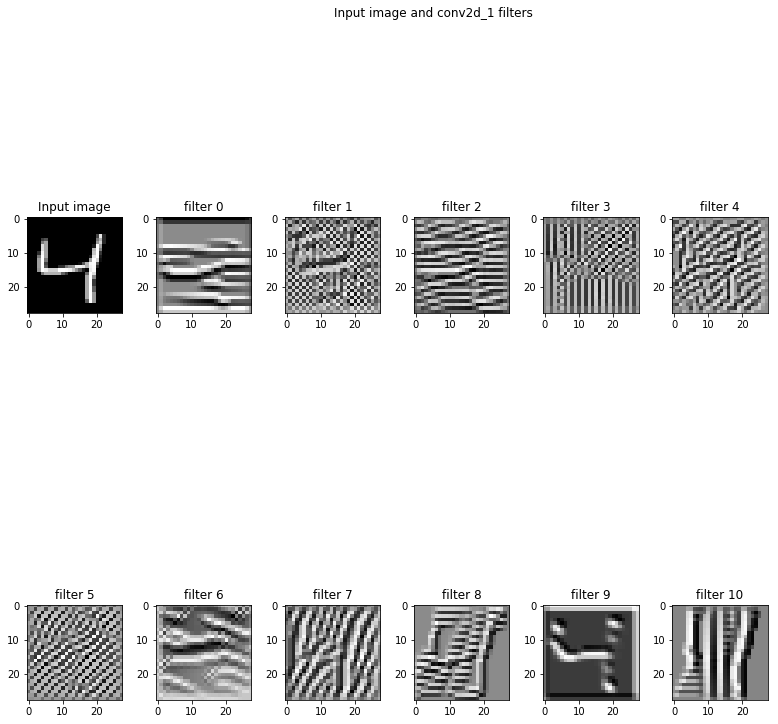

In [16]:
vis_img_in_filter(layer_name = model.layers[0].name, model = model)

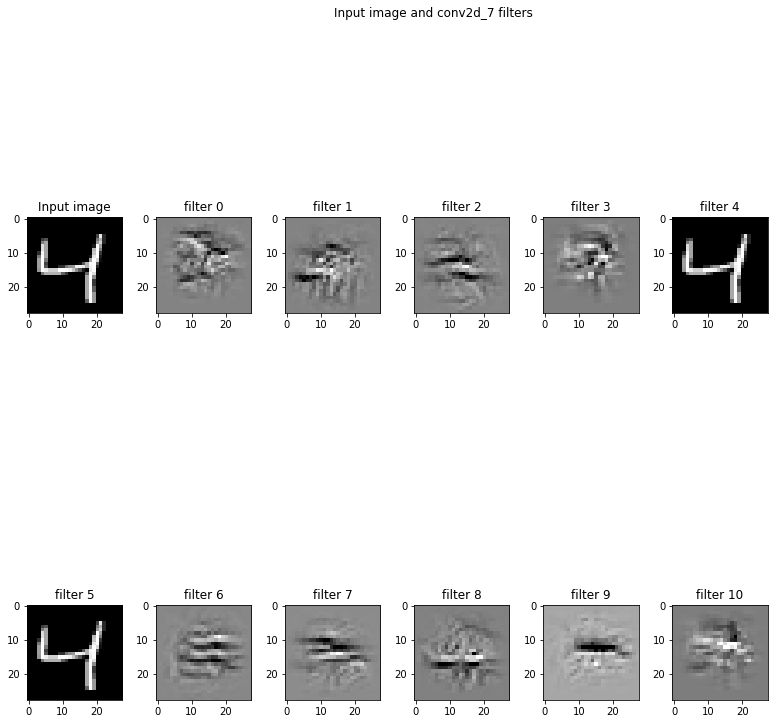

In [17]:
vis_img_in_filter(layer_name = model.layers[7].name, model = model)

# Step 2

- Added batch normalizaion to regularise the model as the model is overfitting
- Added decayed learning rate. For better convergence 

In [18]:
from keras.layers import Activation
model_BN = Sequential()
 
model_BN.add(Convolution2D(16, 3, 3, activation='relu', input_shape=(28,28,1))) #26
model_BN.add(BatchNormalization())

model_BN.add(Convolution2D(20, 3, 3, activation='relu')) #24
model_BN.add(BatchNormalization())


model_BN.add(MaxPooling2D(pool_size=(2, 2)))#11
model_BN.add(Convolution2D(10, 1, 1, activation='relu')) #22
model_BN.add(BatchNormalization())


model_BN.add(Convolution2D(16, 3, 3, activation='relu'))#9
model_BN.add(BatchNormalization())


model_BN.add(Convolution2D(16, 3, 3, activation='relu'))#7
model_BN.add(BatchNormalization())


model_BN.add(Convolution2D(16, 3, 3, activation='relu'))#5
model_BN.add(BatchNormalization())


model_BN.add(Convolution2D(16, 3, 3, activation='relu'))#3
model_BN.add(BatchNormalization())


model_BN.add(Convolution2D(10, 4, 4))
model_BN.add(BatchNormalization())


model_BN.add(Flatten())
model_BN.add(Activation('softmax'))


model_BN.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  after removing the cwd from sys.path.
W0819 18:44:36.618137 140454928721792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (3, 3), activation="relu")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation="relu")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activatio

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 20)        2900      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 20)        80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 10)        210       
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 10)        40        
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (4, 4))`


In [0]:
def scheduler(epoch, lr):
  return round(0.01 * 1/(1 + 0.319 * epoch), 10)


earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./mdl_wts.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model_BN.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_BN.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, Y_test),callbacks=[earlyStopping, mcp_save, LearningRateScheduler(scheduler, verbose=1)])


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 60000 samples, validate on 10000 samples
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
60000/60000 [==============================] - 11s 183us/step - loss: 0.1945 - acc: 0.9603 - val_loss: 0.0665 - val_acc: 0.9783
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0075815011.
60000/60000 [==============================] - 6s 101us/step - loss: 0.0529 - acc: 0.9862 - val_loss: 0.0409 - val_acc: 0.9881
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0061050061.
60000/60000 [==============================] - 6s 100us/step - loss: 0.0383 - acc: 0.9895 - val_loss: 0.0265 - val_acc: 0.9925
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.005109862.
60000/60000 [==============================] - 6s 100us/step - loss: 0.0307 - acc: 0.9914 - val_loss: 0.0289 - val_acc: 0.9917
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0043936731.
60000/60000 [=======

# Accuracy improved to 99.44 %

In [0]:
model_BN.load_weights(filepath = './mdl_wts.hdf5')
score = model_BN.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.021076245080702938, 0.9944]


In [0]:
layer_dict = dict([(layer.name, layer) for layer in model_BN.layers])

# Plotted feature maps
- did not found much difference from the step 1 feature maps
- maybe because of less number of layers

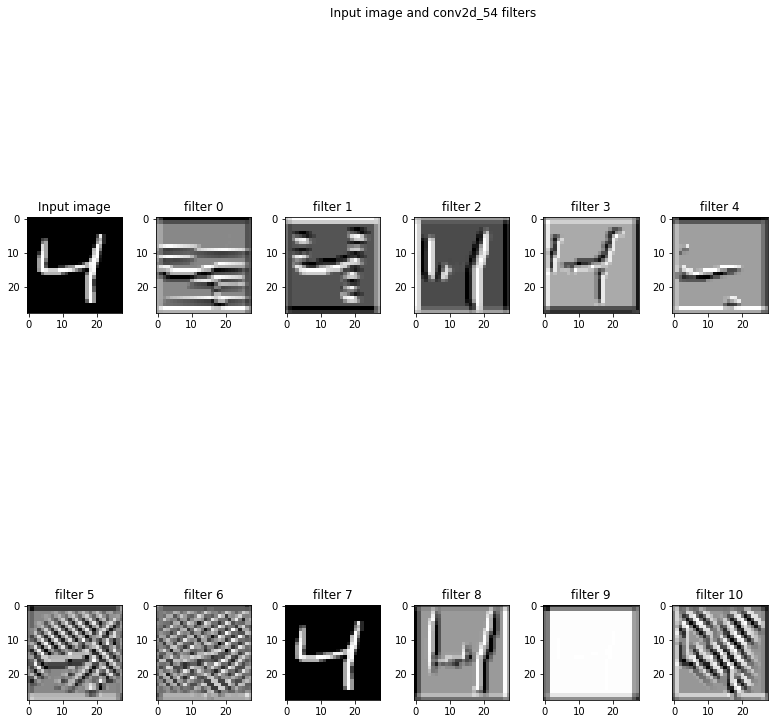

In [0]:
vis_img_in_filter(layer_name = model_BN.layers[0].name, model = model_BN)

In [0]:
# layer_dict = dict([(layer.name, layer) for layer in model.layers])
# vis_img_in_filter(layer_name = model.layers[7].name, model = model)

## Plotting the accuracy of model with BN vs without BN

__observations__
- accuracy has improved because of BN and decay in learning rate
- convergence on test data is really fast with batch normalization
- train data converged slower leaving a scope for further imporvement in model

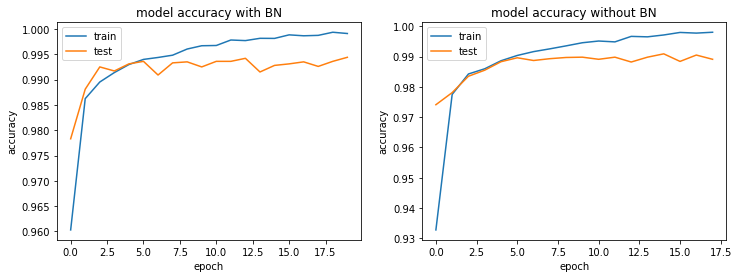

In [0]:
w=10
h=10
fig=plt.figure(figsize=(12, 4))
columns = 2
rows = 1

plt.subplot(121)
plt.plot(model_BN.history.history['acc'])
plt.plot(model_BN.history.history['val_acc'])
plt.title('model accuracy with BN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy without BN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

## Plotting the accuracy of model with BN vs without BN
- Train loss coverged slowly and test loss converged fastly. Resulting in improving accuracy 
- Without BN difference between train and test loss is more 
- With BN difference between train and test loss is less __resulting in reduced ovefitting__

>But still overfitting exists. Lets figure out a way to reduce the overfitting.

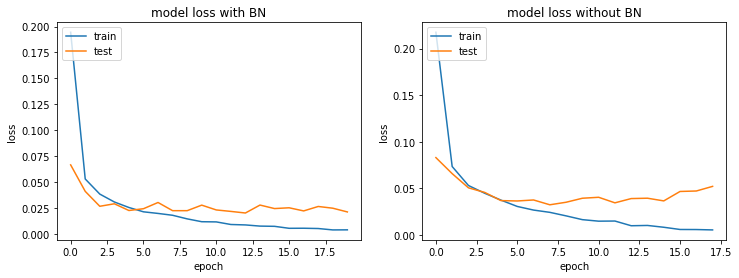

In [0]:
w=10
h=10
fig=plt.figure(figsize=(12, 4))
columns = 2
rows = 1

plt.subplot(121)
plt.plot(model_BN.history.history['loss'])
plt.plot(model_BN.history.history['val_loss'])
plt.title('model loss with BN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss without BN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Step 3

- Added Dropout of 0.05 to reduce overfitting
- have tried different drou out values but 0.05 fit well. As the data images are too small and simple to use large dropouts

In [0]:
from keras.layers import Activation
model_BN_Dout = Sequential()
 
model_BN_Dout.add(Convolution2D(16, 3, 3, activation='relu', input_shape=(28,28,1))) #26
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(Dropout(0.05))

model_BN_Dout.add(Convolution2D(20, 3, 3, activation='relu')) #24
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(Dropout(0.05))


model_BN_Dout.add(MaxPooling2D(pool_size=(2, 2)))#11
model_BN_Dout.add(Convolution2D(10, 1, 1, activation='relu')) #22
model_BN_Dout.add(BatchNormalization())


model_BN_Dout.add(Convolution2D(16, 3, 3, activation='relu'))#9
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(Dropout(0.05))


model_BN_Dout.add(Convolution2D(16, 3, 3, activation='relu'))#7
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(Dropout(0.05))


model_BN_Dout.add(Convolution2D(16, 3, 3, activation='relu'))#5
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(Dropout(0.05))


model_BN_Dout.add(Convolution2D(16, 3, 3, activation='relu'))#3
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(Dropout(0.05))


model_BN_Dout.add(Convolution2D(10, 4, 4))
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(Dropout(0.05))


model_BN_Dout.add(Flatten())
model_BN_Dout.add(Activation('softmax'))


model_BN_Dout.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  after removing the cwd from sys.path.
W0819 17:34:17.535992 139896171947904 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launche

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_25 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 24, 24, 20)        2900      
_________________________________________________________________
batch_normalization_26 (Batc (None, 24, 24, 20)        80        
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 20)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 20)        0         
__________

In [0]:
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)


earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./mdl_wts.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model_BN_Dout.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.003), metrics=['accuracy'])

model_BN_Dout.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, Y_test),callbacks=[earlyStopping, mcp_save, LearningRateScheduler(scheduler, verbose=1)])


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 60000 samples, validate on 10000 samples
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
60000/60000 [==============================] - 14s 233us/step - loss: 0.4345 - acc: 0.8956 - val_loss: 0.0837 - val_acc: 0.9830
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
60000/60000 [==============================] - 7s 115us/step - loss: 0.1757 - acc: 0.9544 - val_loss: 0.0516 - val_acc: 0.9884
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
60000/60000 [==============================] - 7s 115us/step - loss: 0.1353 - acc: 0.9651 - val_loss: 0.0399 - val_acc: 0.9909
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
60000/60000 [==============================] - 7s 116us/step - loss: 0.1141 - acc: 0.9718 - val_loss: 0.0315 - val_acc: 0.9927
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
60000/60000 [=====

# Achieved a score of 99.47% with 14,736 parameters

In [0]:
model_BN_Dout.load_weights(filepath = './mdl_wts.hdf5')
score = model_BN_Dout.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.020081755352346225, 0.9947]


In [0]:
layer_dict = dict([(layer.name, layer) for layer in model_BN_Dout.layers])

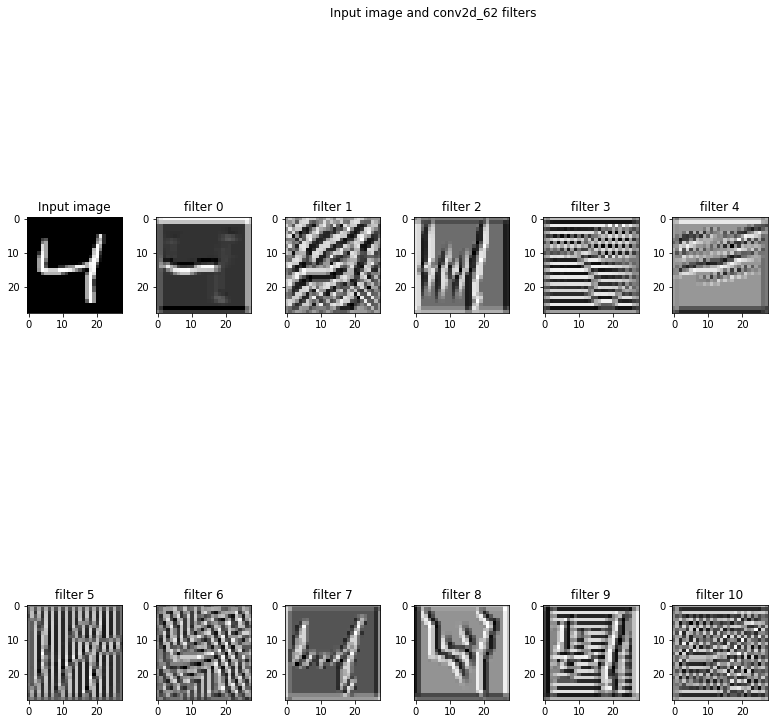

In [0]:
vis_img_in_filter(layer_name = model_BN_Dout.layers[0].name, model = model_BN_Dout)

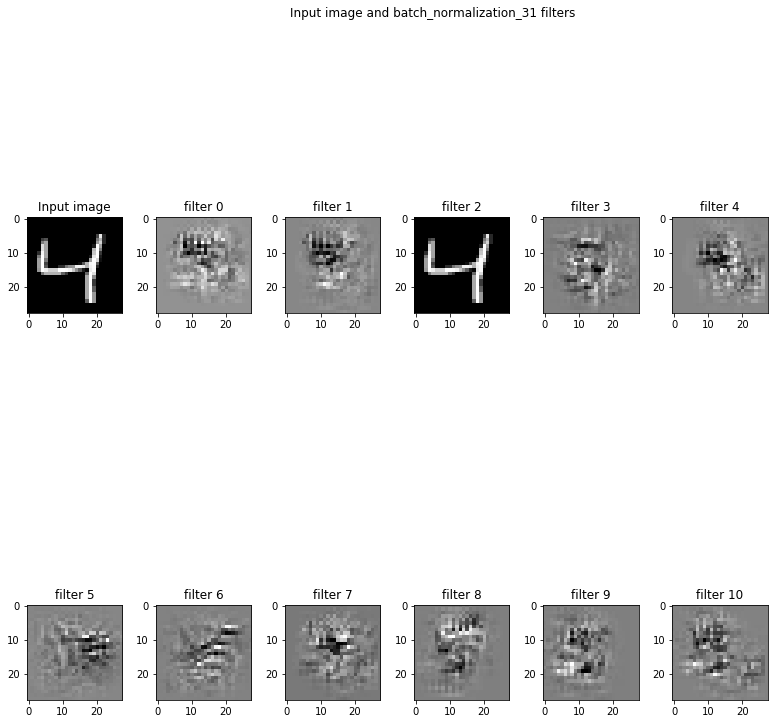

In [0]:
vis_img_in_filter(layer_name = model_BN_Dout.layers[19].name, model = model_BN_Dout)

## accuracy plot with and without dropout
- we can observe that model have underfitted bacause of dropout but still with a better accuracy

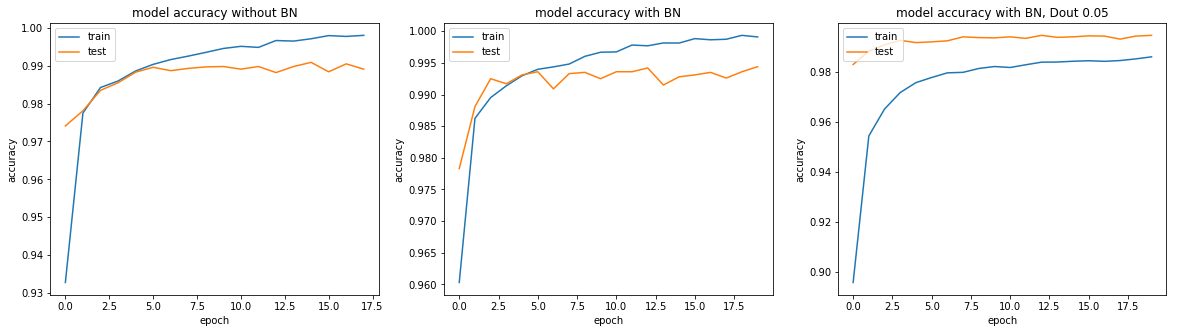

In [0]:
w=10
h=10
fig=plt.figure(figsize=(20, 5))
columns = 3
rows = 1


plt.subplot(131)
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy without BN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(132)
plt.plot(model_BN.history.history['acc'])
plt.plot(model_BN.history.history['val_acc'])
plt.title('model accuracy with BN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(133)
plt.plot(model_BN_Dout.history.history['acc'])
plt.plot(model_BN_Dout.history.history['val_acc'])
plt.title('model accuracy with BN, Dout 0.05')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

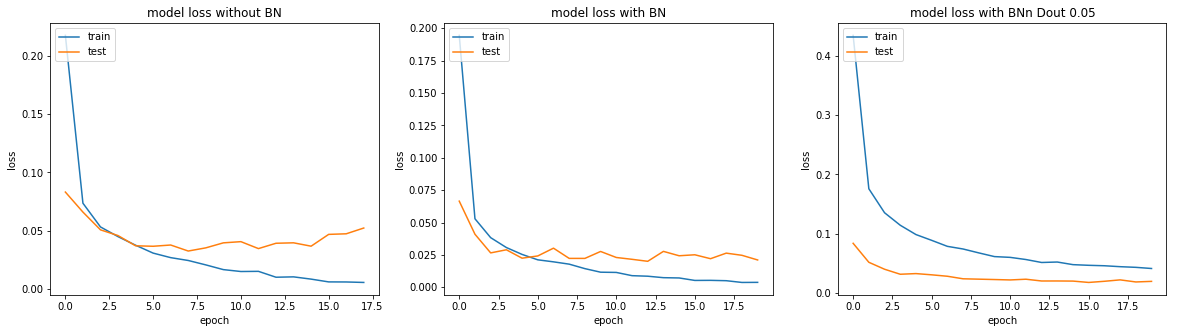

In [0]:
w=10
h=10
fig=plt.figure(figsize=(20, 5))
columns = 3
rows = 1



plt.subplot(131)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss without BN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(132)
plt.plot(model_BN.history.history['loss'])
plt.plot(model_BN.history.history['val_loss'])
plt.title('model loss with BN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(133)
plt.plot(model_BN_Dout.history.history['loss'])
plt.plot(model_BN_Dout.history.history['val_loss'])
plt.title('model loss with BNn Dout 0.05')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()


### In this model i have achieved an accuracy of 99.51%
> NOTE : this model is sam as previous model (ie. no change)

In [0]:
from keras.layers import Activation
model = Sequential()
 
model.add(Convolution2D(16, 3, 3, activation='relu', input_shape=(28,28,1))) #26
model.add(BatchNormalization())
model.add(Dropout(0.05))

model.add(Convolution2D(20, 3, 3, activation='relu')) #24
model.add(BatchNormalization())
model.add(Dropout(0.05))


model.add(MaxPooling2D(pool_size=(2, 2)))#11
model.add(Convolution2D(10, 1, 1, activation='relu')) #22
model.add(BatchNormalization())


model.add(Convolution2D(16, 3, 3, activation='relu'))#9
model.add(BatchNormalization())
model.add(Dropout(0.05))


model.add(Convolution2D(16, 3, 3, activation='relu'))#7
model.add(BatchNormalization())
model.add(Dropout(0.05))


model.add(Convolution2D(16, 3, 3, activation='relu'))#5
model.add(BatchNormalization())
model.add(Dropout(0.05))


model.add(Convolution2D(16, 3, 3, activation='relu'))#3
model.add(BatchNormalization())
model.add(Dropout(0.05))


model.add(Convolution2D(10, 4, 4))
model.add(BatchNormalization())
model.add(Dropout(0.05))


model.add(Flatten())
model.add(Activation('softmax'))


model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to th

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_16 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
dropout_15 (Dropout)         (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 20)        2900      
_________________________________________________________________
batch_normalization_17 (Batc (None, 24, 24, 20)        80        
_________________________________________________________________
dropout_16 (Dropout)         (None, 24, 24, 20)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 20)        0         
__________

# accuracy 99.51% at 17th epoc with 14,736 parameters

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, Y_test), callbacks=[LearningRateScheduler(scheduler, verbose=1)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
60000/60000 [==============================] - 28s 460us/step - loss: 0.4253 - acc: 0.8999 - val_loss: 0.0857 - val_acc: 0.9847
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
60000/60000 [==============================] - 21s 344us/step - loss: 0.1729 - acc: 0.9556 - val_loss: 0.0489 - val_acc: 0.9883
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
60000/60000 [==============================] - 21s 345us/step - loss: 0.1348 - acc: 0.9660 - val_loss: 0.0414 - val_acc: 0.9891
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
60000/60000 [==============================] - 21s 354us/step - loss: 0.1110 - acc: 0.9727 - val_loss: 0.0389 - val_acc: 0.9913
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
60000/60000 [==

In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.019573579585785046, 0.994]


# step 4 
__didnt imporved accuracy, hence step 3 have highest accuracy__
- Tried with different optmiser SGD(stochastic gradient descent)
- Took so many epocs to converge to optimal weights
- Did not gave good accuracy (need to explore why ?)
- Tried with different momentums and learning rates but did not gave better results than adam optmiser.

__most intersting observation is__: Train accuracy is not increaseing with number of epocs unlike adam optmiser . Why? 

In [9]:

from keras.layers import Activation, MaxPooling2D

model_SGD = Sequential() 
model_SGD.add(Convolution2D(16, 3, 3, activation='relu', input_shape=(28,28,1)))
model_SGD.add(BatchNormalization())
model_SGD.add(Dropout(0.05))

model_SGD.add(Convolution2D(24, 3, 3, activation='relu'))
model_SGD.add(BatchNormalization())
model_SGD.add(Dropout(0.05))

model_SGD.add(MaxPooling2D(pool_size=(2, 2)))

model_SGD.add(Convolution2D(24, 3, 3, activation='relu'))
model_SGD.add(BatchNormalization())
model_SGD.add(Dropout(0.05))

model_SGD.add(MaxPooling2D(pool_size=(2, 2)))

model_SGD.add(Convolution2D(30, 3, 3, activation='relu'))
model_SGD.add(BatchNormalization())
model_SGD.add(Dropout(0.05))

model_SGD.add(Convolution2D(10, 3, 3))


model_SGD.add(Flatten())
model_SGD.add(Activation('softmax'))

model_SGD.summary()



W0820 18:18:31.966626 139698867300224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  """
W0820 18:18:32.013657 139698867300224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 18:18:32.022727 139698867300224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 18:18:32.068378 139698867300224 deprecation_wrapper.py:119] From /usr/local/lib/py

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 24)        3480      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 24)        96        
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 24)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (3, 3))`


In [10]:
def scheduler(epoch, lr):
  return round(0.009 * 1/(1 + 0.319 * epoch), 10)

sgd = SGD(lr=0.03, momentum=0.2, decay=0.0005, nesterov=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./mdl_wts.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model_SGD.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model_SGD.fit(X_train, Y_train, batch_size=128, epochs=40, verbose=1, validation_data=(X_test, Y_test),callbacks=[earlyStopping, mcp_save])


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
W0820 18:18:38.131482 139698867300224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0820 18:18:38.275396 139698867300224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 12s 199us/step - loss: 0.1952 - acc: 0.9442 - val_loss: 0.0772 - val_acc: 0.9792
Epoch 2/40
60000/60000 [==============================] - 9s 143us/step - loss: 0.0758 - acc: 0.9779 - val_loss: 0.0533 - val_acc: 0.9834
Epoch 3/40
60000/60000 [==============================] - 9s 143us/step - loss: 0.0586 - acc: 0.9832 - val_loss: 0.0499 - val_acc: 0.9847
Epoch 4/40
60000/60000 [==============================] - 9s 144us/step - loss: 0.0496 - acc: 0.9857 - val_loss: 0.0448 - val_acc: 0.9861
Epoch 5/40
60000/60000 [==============================] - 9s 143us/step - loss: 0.0455 - acc: 0.9861 - val_loss: 0.0410 - val_acc: 0.9867
Epoch 6/40
60000/60000 [==============================] - 9s 144us/step - loss: 0.0420 - acc: 0.9877 - val_loss: 0.0382 - val_acc: 0.9879
Epoch 7/40
60000/60000 [==============================] - 9s 144us/step - loss: 0.0388 - acc: 0.9886 - val_loss: 0.0384 -

In [11]:
model_SGD.load_weights(filepath = './mdl_wts.hdf5')
score = model_SGD.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.02740044596599182, 0.9908]
